<a href="https://colab.research.google.com/github/jej0312/DM_TA/blob/main/2_PCA_FA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA & FA (Principal Component Analysis & Factor Analysis)
- TA: 전은지 (Eunji Jeon)  
- Dept. of Industrial Engineering, Yonsei Univ (Industrial Statistics Lab; ISL 산업통계연구실)
- 문의: `jej_0312_@naver.com`

- 차원의 저주: 변수(차원)가 증가하면서 고차원으로 갈수록 희소(sparse)해짐 (무작위로 두 점의 평균 거리를 산출했을 때 그 거리가 멀어짐)
  - 해결하기 위해 엄청나게 많은 데이터를 확보하는 방법이 있지만, 차원이 늘어날수록 필요한 데이터의 양이 기하급수적으로 증가하여, 현실적으로는 불가능
- 이를 해결하기 위해, 데이터를 저차원으로 투영하는 방법과, 매니폴드를 학습하는 방법이 있음 ([참고](https://fourz.tistory.com/43))
  - 매니폴드를 학습하는 것은 시각화에 있어서는 장점이지만 다루기 까다롭고 느림
  - 따라서, 저차원으로 투영을 통해 차원 축소를 진행

In [1]:
!pip install factor_analyzer # https://pypi.org/project/factor-analyzer/

     |████████████████████████████████| 41 kB 485 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=79794ef254b895a72bcbf7aec61c409bd63dc9604d053bc4122ebd0b69aa45a4
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer


# 1. PCA (Principal Component Analysis)
- "데이터를 정사영시켜 **차원**을 낮춘다면, 어떤 벡터에 정사영 시키는 것이 원 **데이터 구조**를 잘 유지할 수 있을까"에 대한 분석  
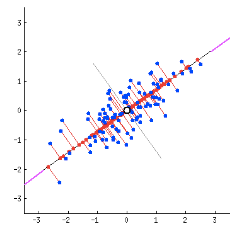

  - 데이터 벡터를 어떤 벡터에 정사영하는 것이 최적의 결과일지
  - 정사영할 벡터를 찾을 때 데이터 분포의 중심을 축(pivot)으로 하는 벡터를 찾는 것이 좋지 않을지


- PCA의 가정
  - 대상이 되는 데이터는 linear하며, 우리가 찾은 선들은 직교
    - linear한 것을 가정, 선형 결합으로 표현하기 때문에 비선형 데이터에 취약할 수 있음
  - 큰 분산을 가지는 축이 중요한 정보를 가지고 있을 것
    - 분산이 높다는 것은, 감소시킨 차원이 일정 부분 변화할 때 기존 변수도 높은 관계성을 가지고 변화한다는 것을 의미  
    - 공분산: feature pairs의 변동이 얼마나 유사한지. 즉, 하나의 feature이 변화할 때 다른 feature의 변화가 얼마나 유사한지
- PCA의 과정: 정사영 후 각 차원의 분산을 최대화하는 것에 관심이 있음  
  - 가장 큰 분산을 가지는 축을 찾은 후, 먼저 찾은 축을 기준으로 직교하는 축들 중에 또 가장 큰 축을 찾는 과정을 거침
  - 새로 생성된 각 차원들은 **선형독립**임
  - 하나의 component가 다른 component보다 적은 분산을 가질 경우 분산이 큰 component를 더 중요하게 반영하여 PCA가 수행될 것임
- PCA를 하는 것은 자료를 요약하고, 메모리를 절약하고 과적합 방지, 정보손실을 적게 하면서도 불필요한 변수들을 새로운 변수로/제거, 이미지의 경우 (e.g., eigenface) 노이즈 감소 등의 효과
- 분류에는 적합하지 않아, (F)LDA, Linear discriminant analysis 등의 방법을 활용할 수 있음

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# 필요한 패키지/모듈 가져오기
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from factor_analyzer import FactorAnalyzer

## Step 1. Dataset & Preprocessing
- Description
  - 25 personality self report items taken from the International Personality Item Pool (ipip.ori.org) were included as part of the Synthetic Aperture Personality Assessment (SAPA) web based personality assessment project. The data from 2800 subjects are included here as a demonstration set for scale construction, factor analysis, and Item Response Theory analysis. Three additional demographic variables (sex, education, and age) are also included. This data set is deprecated and users are encouraged to use bfi.
  - A data frame with 2800 observations on the following 28 variables. (The q numbers are the SAPA item numbers).
  - features
    - A1: Am indifferent to the feelings of others. (q_146)
    - A2: Inquire about others' well-being. (q_1162)
    - A3: Know how to comfort others. (q_1206)
    - A4: Love children. (q_1364)
    - A5: Make people feel at ease. (q_1419)
    - C1: Am exacting in my work. (q_124)
    - C2: Continue until everything is perfect. (q_530)
    - C3: Do things according to a plan. (q_619)
    - C4: Do things in a half-way manner. (q_626)
    - C5: Waste my time. (q_1949)
    - E1: Don't talk a lot. (q_712)
    - E2: Find it difficult to approach others. (q_901)
    - E3: Know how to captivate people. (q_1205)
    - E4: Make friends easily. (q_1410)
    - E5: Take charge. (q_1768)
    - N1: Get angry easily. (q_952)
    - N2: Get irritated easily. (q_974)
    - N3: Have frequent mood swings. (q_1099)
    - N4: Often feel blue. (q_1479)
    - N5: Panic easily. (q_1505)
    - O1: Am full of ideas. (q_128)
    - O2: Avoid difficult reading material.(q_316)
    - O3: Carry the conversation to a higher level. (q_492)
    - O4: Spend time reflecting on things. (q_1738)
    - O5: Will not probe deeply into a subject. (q_1964)
    - gender: Males = 1, Females = 2
    - education: 1 = HS, 2 = finished HS, 3 = some college, 4 = college graduate 5 = graduate degree
    - age: age in years
- Source: https://vincentarelbundock.github.io/Rdatasets/doc/psych/bfi.html
- Data Source: https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jej0312/DM_TA/main/data/bfi.csv', index_col =0)
data.drop(['gender', 'education', 'age'], axis=1, inplace=True)
data.dropna(inplace=True)
# data.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25']
data.head()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,...,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0
61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,...,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0
61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,...,4.0,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0
61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,...,2.0,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0
61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,...,2.0,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 61617 to 67560
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      2436 non-null   float64
 1   A2      2436 non-null   float64
 2   A3      2436 non-null   float64
 3   A4      2436 non-null   float64
 4   A5      2436 non-null   float64
 5   C1      2436 non-null   float64
 6   C2      2436 non-null   float64
 7   C3      2436 non-null   float64
 8   C4      2436 non-null   float64
 9   C5      2436 non-null   float64
 10  E1      2436 non-null   float64
 11  E2      2436 non-null   float64
 12  E3      2436 non-null   float64
 13  E4      2436 non-null   float64
 14  E5      2436 non-null   float64
 15  N1      2436 non-null   float64
 16  N2      2436 non-null   float64
 17  N3      2436 non-null   float64
 18  N4      2436 non-null   float64
 19  N5      2436 non-null   float64
 20  O1      2436 non-null   float64
 21  O2      2436 non-null   int64  


- PCA을 수행하기 전 standardization을 통해 분산을 고정하는 것이 중요함
  - 데이터의 스케일에 따라 주성분의 설명 가능한 분산량이 달라질 수 있음 
  - 따라서, scaling(centering)을 통해 변수가 가진 값의 크기에 따라 설명 가능한 분산량이 왜곡되는 것에 따른 모델 성능이 저하를 방지함
    - 예를 들어, 키(m)와 몸무게(kg)가 다른 scale을 가지고 있을 때 (키가 더 적게 변화) scaling을 하지 않으면 몸무게가 maximal variance의 방향을 결정할 것임. 따라서 키(m)의 변화 1은 몸무게(kg)의 변화 1보다 더 중요하게 반영이 될 것인데 이렇게 다른 가중치를 두는 것을 옳지 않음
  - 공분산 행렬을 계산할 때 각 feature의 평균은 0으로 맞춰주어야 결과에 대해 직관적으로 해석하기 용이함
    - image.png

- 더 자세한 사항은 [다음](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)과 [다음](https://angeloyeo.github.io/2019/07/27/PCA.html)을 참고.

In [5]:
# 열별로 scaling (z-standardization)
from sklearn.preprocessing import StandardScaler
data_scale = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index = data.index)

In [6]:
data_scale.mean(axis=0).head()

A1   -2.061615e-16
A2   -5.614921e-16
A3   -7.031412e-16
A4    1.956563e-16
A5   -2.829337e-16
dtype: float64

In [7]:
data_scale.cov() # 공분산행렬

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5
A1,1.000411,-0.351050,-0.273748,-0.156818,-0.192777,0.014704,0.012924,-0.020595,0.115121,0.038309,...,0.168348,0.139871,0.092404,0.042157,0.015187,0.005784,0.066203,-0.063814,-0.090549,0.099206
A2,-0.351050,1.000411,0.503248,0.351000,0.397563,0.103025,0.129627,0.188895,-0.146355,-0.121156,...,-0.093666,-0.050496,-0.040424,-0.086771,0.019696,0.125685,0.013964,0.165387,0.082643,-0.080871
A3,-0.273748,0.503248,1.000411,0.385076,0.515890,0.114258,0.146571,0.129444,-0.121165,-0.153875,...,-0.083300,-0.092511,-0.039174,-0.127160,-0.040159,0.150148,0.006590,0.226426,0.032280,-0.041768
A4,-0.156818,0.351000,0.385076,1.000411,0.325778,0.094851,0.226547,0.133119,-0.172342,-0.249778,...,-0.106689,-0.155352,-0.073918,-0.171298,-0.015142,0.057099,0.037779,0.071012,-0.049814,0.027319
A5,-0.192777,0.397563,0.515890,0.325778,1.000411,0.134747,0.116911,0.130873,-0.125582,-0.167105,...,-0.204849,-0.198918,-0.138529,-0.215434,-0.081438,0.162663,-0.006991,0.238289,0.011359,-0.050470
C1,0.014704,0.103025,0.114258,0.094851,0.134747,1.000411,0.438403,0.317400,-0.362640,-0.261187,...,-0.071984,-0.038196,-0.025487,-0.098075,-0.047989,0.179323,-0.129316,0.196643,0.100231,-0.130525
C2,0.012924,0.129627,0.146571,0.226547,0.116911,0.438403,1.000411,0.362975,-0.396252,-0.303944,...,-0.019959,-0.005588,0.003190,-0.044359,0.051233,0.161108,-0.057370,0.192760,0.047446,-0.066617
C3,-0.020595,0.188895,0.129444,0.133119,0.130873,0.317400,0.362975,1.000411,-0.357971,-0.351093,...,-0.079126,-0.066908,-0.077447,-0.122225,-0.023518,0.091179,-0.029616,0.058904,0.011365,-0.002810
C4,0.115121,-0.146355,-0.121165,-0.172342,-0.125582,-0.362640,-0.396252,-0.357971,1.000411,0.487751,...,0.215940,0.158411,0.201988,0.270744,0.197143,-0.093599,0.208158,-0.083061,0.053036,0.189621
C5,0.038309,-0.121156,-0.153875,-0.249778,-0.167105,-0.261187,-0.303944,-0.351093,0.487751,1.000411,...,0.216503,0.246400,0.241698,0.354810,0.179083,-0.085665,0.122646,-0.074159,0.135538,0.055827


## Step 2. Principle component 수 선택
- PC 선택: 몇 개까지 선택할지는 분석가의 결정에 따름
  - 방안 1: Eigen value가 1 이상일 때까지
  - 방안 2: Scree plot 그래프 기울기가 완만해지기 전의 값까지
  - 방안 3: 약 80% 이상의 분산을 설명하는 PC 개수 채택

In [8]:
# PCA 진행
pca = PCA(random_state=312)
X_p = pca.fit_transform(data_scale)

### 방안 1. Eigen value가 1 이상일 때까지
- Eigen vector (고유 벡터): 데이터가 어떤 방향으로 분산되어 있는지. 행렬이 벡터에 작용하는 주축(principal axis)의 방향을 나타냄
  - 원 차원의 수만큼 eigenvector가 생성됨
  - 주축 위에 정사영하는 것이 분산이 가장 큰 결과를 얻을 수 있음 (선형변환을 했을 때 크기만 바뀌고 방향이 변하지 않도록 함)
  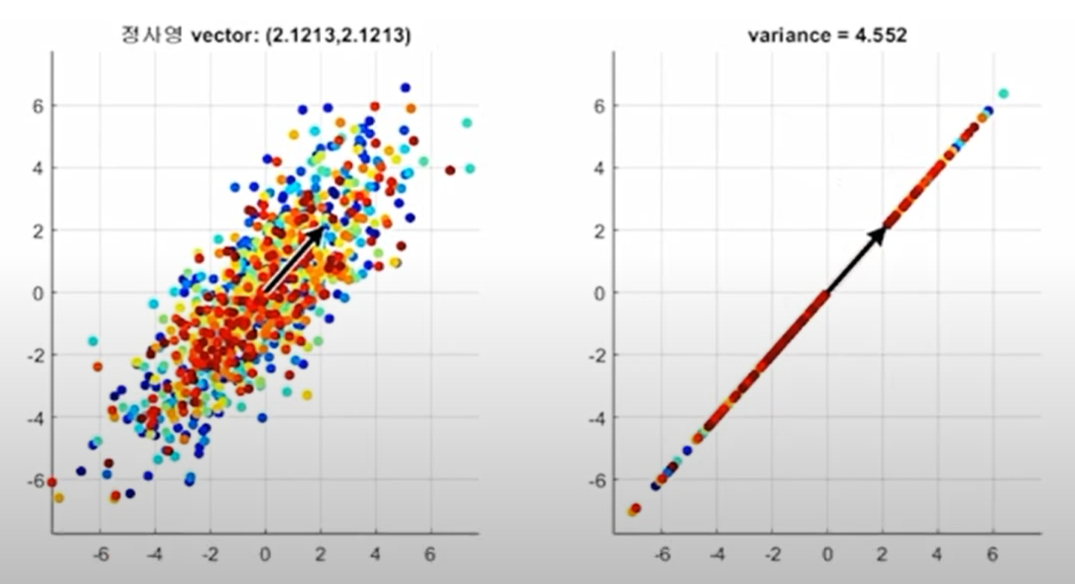
- Eigen value (고유 값): 고유벡터 방향으로 얼마만큼의 크기로 벡터공간이 늘려지는가, 즉 고유벡터의 크기를 의미함
- Eigen value가 큰 순서대로 고유 벡터를 정렬하는 것이, 중요한 순서대로 주성분을 구성한다는 의미

In [9]:
# Eigen value
fa = FactorAnalyzer(n_factors=data_scale.shape[1], rotation=None) # rotation: 
fa.fit(data_scale)

ev, v = fa.get_eigenvalues()
print('eigen value:', ev,'\n')

print('적합한 PC 개수:', sum(ev >= 1))

eigen value: [5.13431118 2.75188667 2.14270195 1.85232761 1.54816285 1.07358247
 0.83953893 0.79920618 0.71898919 0.68808879 0.67637336 0.65179984
 0.62325295 0.59656284 0.56309083 0.54330533 0.51451752 0.49450315
 0.48263952 0.448921   0.42336611 0.40067145 0.38780448 0.38185679
 0.26253902] 

적합한 PC 개수: 6


### 방안 2. Scree plot 그래프 기울기가 완만해지기 전까지
- Scree plot: 고유값-주성분의 분산 변화를 보는 그래프로, 고유값 변화율이 완만해지는 부분이 필요한 주성분의 수

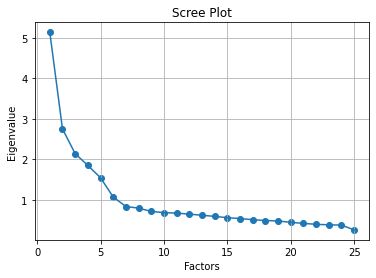

In [10]:
# 시각화 1
plt.scatter(range(1, data_scale.shape[1]+1),ev)
plt.plot(range(1,data_scale.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

- Factors가 (6 -> 7) 이후로 (7 -> 8)에서 기울기가 완만해지는 것을 보임
  - 따라서 기울기가 완만해지기 전의 값으로, 적합한 PC 개수는 6

In [11]:
# 분산 설명 비율
each_variance_ratio = pca.explained_variance_ratio_
print('분산 설명 비율:\n', each_variance_ratio) # 각 PC별 분산 설명 비율

cumsum = np.cumsum(each_variance_ratio)
print('누적 분산 설명 비율:\n', cumsum) # 고유값을 기준으로 설명 가능한 분산 (누적)

분산 설명 비율:
 [0.20537245 0.11007547 0.08570808 0.0740931  0.06192651 0.0429433
 0.03358156 0.03196825 0.02875957 0.02752355 0.02705493 0.02607199
 0.02493012 0.02386251 0.02252363 0.02173221 0.0205807  0.01978013
 0.01930558 0.01795684 0.01693464 0.01602686 0.01551218 0.01527427
 0.01050156]
누적 분산 설명 비율:
 [0.20537245 0.31544791 0.40115599 0.4752491  0.53717561 0.58011891
 0.61370047 0.64566871 0.67442828 0.70195183 0.72900677 0.75507876
 0.78000888 0.80387139 0.82639503 0.84812724 0.86870794 0.88848807
 0.90779365 0.92575049 0.94268513 0.95871199 0.97422417 0.98949844
 1.        ]


- PC 6까지 채택할 경우, 누적 분산 설명 비율은 약 58%

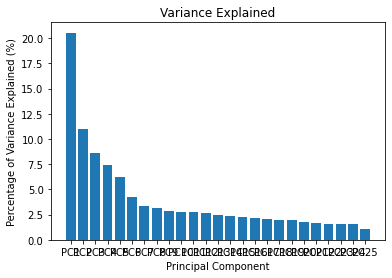

In [12]:
# 시각화 2
percent_variance = np.round(each_variance_ratio* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained (%)')
plt.xlabel('Principal Component')
plt.title('Variance Explained')
plt.show()

### 방안 3. 약 80% 이상의 분산을 설명하는 PC 건수 채택

In [13]:
d = np.argmax(cumsum >= 0.80) +1 #누적된 설명가능한 분산의 비율이 0.85 이상
print('적합한 PC 개수:', d) # 17개 선택 (PC16까지 활용)

적합한 PC 개수: 14


## Step 3. PCA
- 방안 1, 방안 2에서 공통적으로 제시한 결과를 기반으로, PC 6까지 사용하여 실습을 진행

In [25]:
# PCA 진행
pca = PCA(n_components=6,random_state=312) # n_components를 재설정
pca_out = pca.fit(data_scale)
X_p = pca.fit_transform(data_scale)

In [15]:
# 각 PC를 이루는 변수들의 조합 구성 (25X6): Eigen Vector
pd.DataFrame(pca.components_.T, 
             columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], 
             index=data.columns)

,PC1,PC2,PC3,PC4,PC5,PC6
A1,0.110202,0.015678,0.118336,-0.030103,0.490322,-0.433022
A2,-0.218899,-0.188507,-0.153868,-0.092109,-0.334325,0.161054
A3,-0.245872,-0.190752,-0.201482,-0.067951,-0.252857,-0.065282
A4,-0.201804,-0.074954,-0.129781,-0.240818,-0.190713,-0.026484
A5,-0.270366,-0.114126,-0.210353,-0.015796,-0.149871,-0.195231
C1,-0.165827,-0.092522,0.357099,-0.154059,0.031908,-0.123721
C2,-0.159166,-0.130469,0.345587,-0.280455,-0.005467,-0.153837
C3,-0.154533,-0.034495,0.269024,-0.324141,-0.025775,-0.061620
C4,0.217423,-0.079365,-0.326138,0.204618,-0.000007,-0.316722
C5,0.231171,-0.114900,-0.201331,0.257624,-0.085076,-0.130692


In [16]:
np.cumsum(pca.explained_variance_ratio_)

array([0.20537245, 0.3154477 , 0.40115552, 0.47524658, 0.53716937,
       0.57996796])

In [17]:
X_pp = pd.DataFrame(X_p, 
                    columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], 
                    index = data.index)
X_pp

,PC1,PC2,PC3,PC4,PC5,PC6
61617,2.370291,1.857836,-2.560924,-0.495954,0.762391,0.615441
61618,0.372959,-0.151099,-1.129518,0.309282,1.021036,0.484816
61620,0.831932,-0.662131,0.505038,0.431168,1.580970,0.059213
61621,1.468606,1.062750,-2.141302,-0.568901,0.690936,-1.443221
61622,0.350793,1.005361,-0.622468,-0.714648,1.538227,0.688743
...,...,...,...,...,...,...
67547,4.066973,-1.058731,2.064906,0.573307,0.239381,0.645306
67549,0.770098,-1.497271,0.447062,2.002434,0.795669,-0.953141
67556,-1.568922,0.188865,1.642908,0.797597,1.893447,0.587701
67559,1.539237,-0.946506,1.670348,1.235719,3.020288,-0.132902


## Step 4. Plot

- 차원을 축소한 결과를 plot

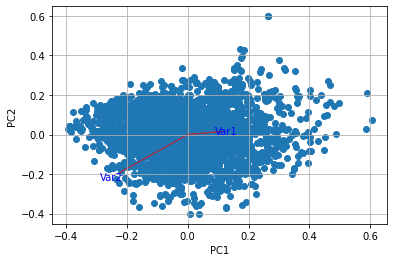

In [52]:
def myplot(score,coeff,labels=None):
    xs = score.iloc[:,0]
    ys = score.iloc[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'b', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'b', ha = 'center', va = 'center')
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_pp.iloc[:,0:2],pca.components_.T[0:2, :])
plt.show()

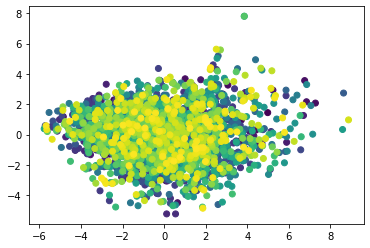

In [ ]:
# Principal Component Pattern Plot 1
plt.scatter(x=X_pp['PC1'],y=X_pp['PC2'], c=X_pp.index)

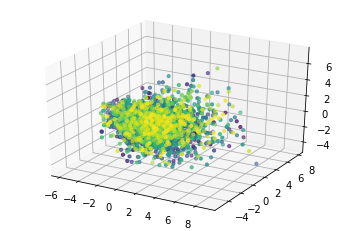

In [ ]:
fig = plt.figure()
ax = fig.gca(projection = '3d')

ax.scatter(X_pp['PC1'],X_pp['PC2'],X_pp['PC3'], s=10, c = X_pp.index)
plt.show()

# 2. FA (Factor Analysis)
- PCA와 마찬가지로, 요인 분석 (Factor analysis) 후에는 더 적은 차원의 변수들로 차원 축소
  - 차원을 축소함으로써 자료를 요약할 수 있고, 변인들이 공통 요인으로 묶일 수 있는지와 상호관계를 판단할 수 있으며, 불필요한 변수를 제거할 수 있음
- 요인분석은 PCA와 달리 데이터에 대한 가정을 수립하고 그에 따른 적합도를 검증하는 통계 모델 ([참고](https://pizzathief.oopy.io/pca-and-fa))
  - 데이터의 변수들이 가지고 있는 **공분산의 구조**를 밝히고, 어떤 요인으로 인해 두 변수가 함께 변화하는 것인지를 찾아내는 것이 목적 (PCA의 경우 최대 분산량을 설명) 
  - FA에서 관찰 변수들이 영향을 받는 요인: 공통요인(common factor)과 고유요인(unique factor)

## Step 1. 요인 분석 전 검정
- 전제조건 ([참고](https://ysyblog.tistory.com/124))
  - 변수: 등간척도/비율척도로 측정한 양적 변수
  - 관찰치: 정규분포이며 상호 독립이어야 하며, 변수별 분산이 동일해야 함
  - 모상관 행렬이 단위 행렬이라는 가설이 기각되어야 함 -> KMO/Bartleet 검정
  - 변수 간 일정 수준 이상의 상관관계가 존재해야 함 -> `corr()`을 통해 확인

- Bartlett Test
  - 요인분석 모형의 적합성 여부 검정 (H0: 상관관계 행렬이 단위행렬이다)
    - 카이제곱 분포를 이용해 검정
  - 귀무가설이 기각되어야 (p-value <= 0.05) 요인분석 모델 사용가능

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(data_scale)
chi_square_value, p_value # p-value < 0.05 --> 귀무가설 기각

(18170.96635086896, 0.0)

- KMO Test (Kaiser-Meyer-Olkin Test)
  - 변수들간 상관관계가 다른 변수에 의해 잘 설명되는 정도를 나타내는 값 (관측된 모든 변수 간 분산 비율)
    - 입력 변수들 간 상관계수제곱들과 편상관계수제곱들을 모두 더한 값 중에서 상관계수제곱의 합이 차지하는 비율 값
  - 이 값이 작으면 요인분석을 위한 변수들의 선정이 적절하지 못하다는 것을 의미
  - 일반적으로 0.9 이상이면 아주 좋음, 0.8 이상이면 꽤 좋음, 0.7 이상이면 적당함, 0.6 이상이면 평범함, 0.5 미만이면 안 좋음
  - 변수가 최소 3개 이상일 경우 사용 가능

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(data_scale)
kmo_model # 0.8 이상이므로 꽤 좋음

0.8485397221949228

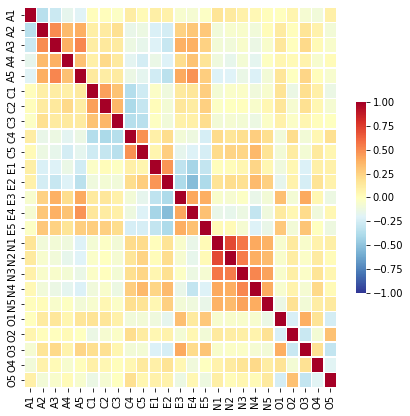

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )
sns.heatmap(data_scale.corr(), 
            cmap = 'RdYlBu_r', 
            # annot = True,   # 실제 값을 표시한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## Step 2. Factor 개수 선택

PCA과정과 동일하게 Eigen value가 1 이상일 때 까지 (또는, 그래프기울기가 완만해지기 전까지)를 채택.  
따라서 본 예시에서는 6개의 factors 선택

## Step 3. Factor Analysis
- `FactorAnalyzer()`의 파라미터는 [여기](https://factor-analyzer.readthedocs.io/en/latest/index.html)에서 확인 가능
  - method
    - `ml`: maximum likelihood
    - `minres`: minimum residual
  - rotation: 각 요인에 변수들이 할당되어 해석되는 구조를 위해 회전(rotation)을 진행
    - 회전을 함으로써 추출된 요인과 입력변수 간 관계를 명확히 파악하고 이해할 수 있음 ([참고1](https://socialinnovation.tistory.com/149), [참고2](https://m.blog.naver.com/shoutjoy/221802826087))

    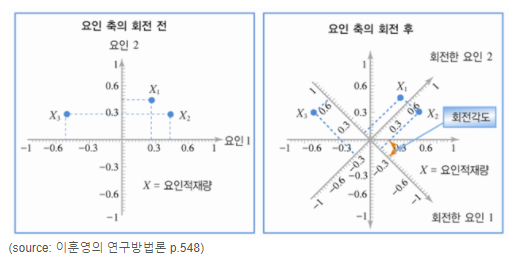

    - 직각(orthogonal) 회전: 요인 간 상관이 없도록 제약.     
    - 사각(oblique) 회전: 요인 축 간의 관계를 어느 정도 허용하는, 다소 유연한 방법으로, 요인들 사이의 상관이 존재함을 받아들이고 회전에 반영. 공분산(covariance)이 존재할 수 있음.
    - `FactorAnalyzer` 모듈에서 제공하는 요인회전방식은 다음과 같음.
        - varimax (orthogonal rotation)
        - oblimax (orthogonal rotation)
        - promax (oblique rotation)
        - oblimin (oblique rotation)
    - 이 외에도 3가지의 회전 방식을 제공하고 있음. 자세한 것은 [다음](https://m.blog.naver.com/shoutjoy/221802826087)을 참고

In [ ]:
fa = FactorAnalyzer(n_factors=6, rotation = "varimax")
fa.fit(data_scale)

FactorAnalyzer(n_factors=6, rotation='varimax', rotation_kwargs={})

- Factor analysis (FA): 요인 적재량은 각 변수와 요인 간의 관계 정도를 나타내는 값으로, 일종의 회귀계수
  - 일반적으로 0.3 이상이면 유의미한 관계가 있다고 볼 수 있음
  - 제곱 값은 회귀계수의 결정계수($R^2$)와 같음 -> 해당 변수를 해당 요인이 얼마나 잘 설명해주는가

In [ ]:
fa_result_loading = pd.DataFrame(fa.loadings_, 
                                 columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6'],
                                 index=data_scale.columns)
fa_result_loading

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
A1,0.095220,0.040783,0.048734,-0.530987,-0.113057,0.161216
A2,0.033131,0.235538,0.133714,0.661141,0.063734,-0.006244
A3,-0.009621,0.343008,0.121353,0.605933,0.033990,0.160106
A4,-0.081518,0.219717,0.235140,0.404594,-0.125338,0.086356
A5,-0.149616,0.414458,0.106382,0.469698,0.030977,0.236519
C1,-0.004358,0.077248,0.554582,0.007511,0.190124,0.095035
C2,0.068330,0.038370,0.674545,0.057055,0.087593,0.152775
C3,-0.039994,0.031867,0.551164,0.101282,-0.011338,0.008996
C4,0.216283,-0.066241,-0.638475,-0.102617,-0.143846,0.318359
C5,0.284187,-0.180812,-0.544838,-0.059955,0.025837,0.132423


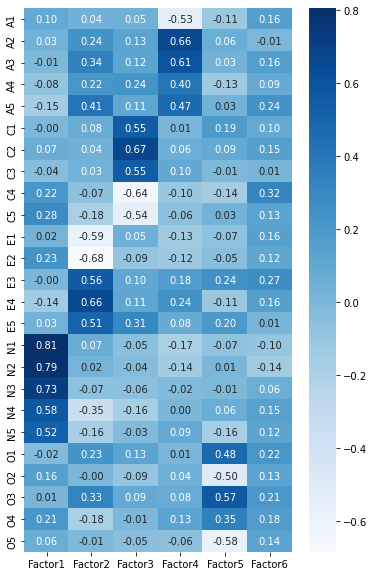

In [ ]:
# 시각화
plt.figure(figsize=(6,10))
sns.heatmap(fa_result_loading, cmap="Blues", annot=True, fmt='.2f')

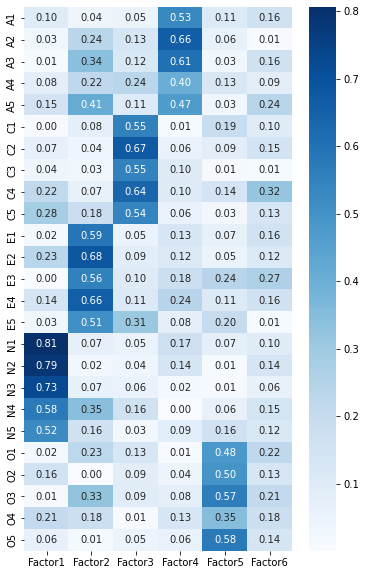

In [ ]:
# 시각화
plt.figure(figsize=(6,10))
sns.heatmap(np.abs(fa_result_loading), cmap="Blues", annot=True, fmt='.2f')

- heat map을 보면, 요인5(6번째 요인)은 변수에 대해 높은 적재량을 가진 값(특징적인 값)이 없음
- 따라서 5가지 요인을 최종 선택

In [ ]:
# 최종 요인 5개 선택
fa = FactorAnalyzer(n_factors=5, rotation = "varimax")
fa.fit(data_scale)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [ ]:
fa_result_loading_final = pd.DataFrame(fa.loadings_, 
                                       columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'],
                                       index=data_scale.columns)
fa_result_loading_final

,Factor1,Factor2,Factor3,Factor4,Factor5
A1,0.111126,0.040465,0.022798,-0.428166,-0.077931
A2,0.029588,0.213716,0.139037,0.626946,0.062139
A3,0.009357,0.317848,0.109331,0.650743,0.056196
A4,-0.066476,0.204566,0.230584,0.435624,-0.112700
A5,-0.122113,0.393034,0.087869,0.537087,0.066708
C1,0.010416,0.070184,0.545824,0.038878,0.209584
C2,0.089574,0.033270,0.648731,0.102782,0.115434
C3,-0.030855,0.023907,0.557036,0.111578,-0.005183
C4,0.240410,-0.064984,-0.633806,-0.037498,-0.107535
C5,0.290318,-0.176395,-0.562467,-0.047525,0.036822


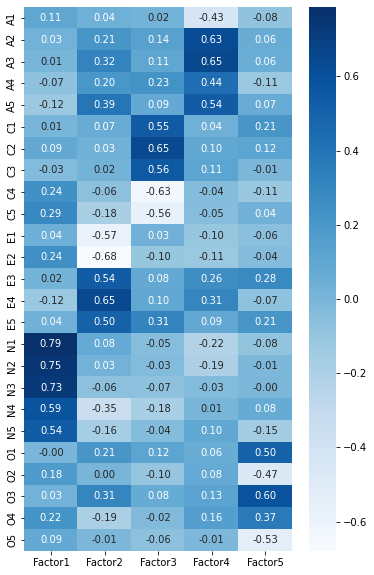

In [ ]:
# 시각화
plt.figure(figsize=(6,10))
sns.heatmap(fa_result_loading_final, cmap="Blues", annot=True, fmt='.2f')

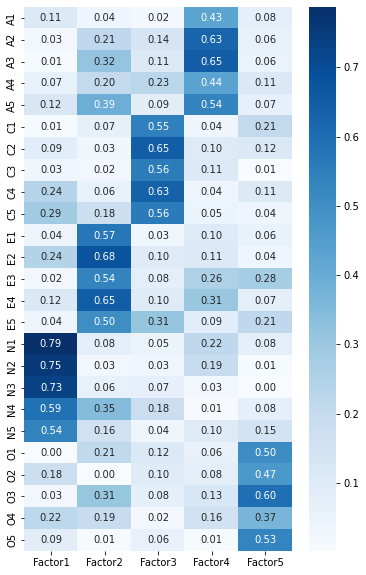

In [ ]:
# 시각화
plt.figure(figsize=(6,10))
sns.heatmap(np.abs(fa_result_loading_final), cmap="Blues", annot=True, fmt='.2f') # 절대값으로 확인

## Step 4. Results

In [ ]:
fa.get_factor_variance() # 각 factor의 variance
fa_result_fromLoading = pd.DataFrame(fa.get_factor_variance(), columns = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'])
fa_result_fromLoading.index = ['SS Loadings', 'Proportion Var', 'Cumulative Var']
fa_result_fromLoading

,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,2.709633,2.473090,2.041106,1.844498,1.522153
Proportion Var,0.108385,0.098924,0.081644,0.073780,0.060886
Cumulative Var,0.108385,0.207309,0.288953,0.362733,0.423619


- 5개의 factor로 설명 가능한 분산은 42%

- 데이터 [Description](https://colab.research.google.com/drive/17gzMV3wHP-ddHPzL_mTYuSrDyAm9Oeka#scrollTo=pLAFvAIn1tgl&line=1&uniqifier=1)을 참고하여 Factors의 naming 진행
  - Factor1: Neuroticism 신경질적 성향
  - Factor2: Extraversion 외향성
  - Factor3: Conscientiousness 성실성
  - Factor4: Agreeableness 우호성
  - Factor5: Openess 개방성

In [ ]:
# Factor Analysis가 적용된 dataset (scaled)
X_f = fa.fit_transform(data_scale)
X_ff = pd.DataFrame(X_f[:,:5], 
                    columns = ['Neuroticism','Extraversion','Conscientiousness','Agreeableness','Openess'], 
                    index = data_scale.index)
X_ff

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
61617,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
61618,0.084369,0.559311,-0.601521,-0.189341,-0.248384
61620,0.520534,0.318235,0.025646,-0.751136,0.204503
61621,-0.197064,0.057696,-1.019263,0.064286,-1.029492
61622,-0.329835,0.408754,-0.058843,-0.820454,-0.691042
...,...,...,...,...,...
67547,1.308046,-1.152403,-0.104197,-1.146411,0.412042
67549,0.732472,0.252206,-0.587511,-0.317781,1.025564
67556,-0.223267,0.721169,0.787110,-1.058480,0.925103
67559,0.920520,0.749337,0.070953,-2.135145,0.673460


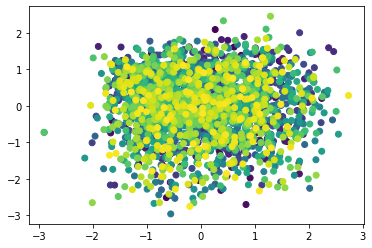

In [ ]:
# Score Plot 1
plt.scatter(x=X_ff['Neuroticism'],y=X_ff['Extraversion'], c=X_ff.index)

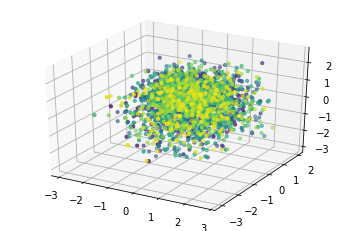

In [ ]:
fig = plt.figure()
ax = fig.gca(projection = '3d')

ax.scatter(X_ff['Neuroticism'],X_ff['Conscientiousness'],X_ff['Extraversion'], s=10, c = X_ff.index)
plt.show()

# PCA v.s. EFA  
| 특징 | PCA | FA (EFA) |
|:--:|:--:|:--:|
| 단위 | 주성분 (분산량에 따라 잘 설명하는 주성분이 존재) | 잠재된 요인 (동등하게 중요한 몇 개의 요인으로 설명) |
| 장점 | 차원 축소, 다중 공선성 감소, 연산속도 개선 | 차원 축소, 다중 공선성 감소, 연산속도 개선 |
| 해석 | 주성분1, 주성분2, ... | Factor 라벨링/네이밍 필요 |
| 방식 | x로 주성분 설명 | 요인으로 x 설명 |
| 개수 | 일반적으로 2-3개 | 정해진 개수 X |
| 사용 | 차원 축소 | X를 잘 이해하고 탐색할 때 |

# Appendices
## 탐색적 요인 분석 (EFA; Exploratory Factor Analysis)
- Factor를 사전에 정하지 않고, 데이터 탐색 (분석)을 통해 Factor 설정하는 것
- 위에서 했던 실습과 같은 경우는 EFA에 해당함

## 확증적 요인 분석 (CFA; Confirmatory Factor Analysis)
- 선행연구 및 강한 심증 등을 통해 Factor의 구성 요소 (variables)를 사전에 정하여, Factor를 미리 선정한 뒤, 이를 검증하는 것
- CFA의 경우, 신뢰도 계수 (Cronbach's alpha)를 사용

In [ ]:
# 신뢰도계수 (Cronbach's alpha 계산)
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems/(nitems-1))*(1-(itemvars.sum()/tscores.var(ddof=1)))

In [ ]:
factors = ['Neuroticism','Extraversion','Conscientiousness','Agreeableness','Openess']
factors_items_dict={}

factors_items_dict[factors[0]] = ['N1','N2','N3','N4','N5']
factors_items_dict[factors[1]] = ['E1','E2','E3','E4','E5']
factors_items_dict[factors[2]] = ['C1','C2','C3','C4','C5']
factors_items_dict[factors[3]] = ['A1','A2','A3','A4','A5']
factors_items_dict[factors[4]] = ['O1','O2','O3','O4','O5']

factors_items_dict

{'Agreeableness': ['A1', 'A2', 'A3', 'A4', 'A5'],
 'Conscientiousness': ['C1', 'C2', 'C3', 'C4', 'C5'],
 'Extraversion': ['E1', 'E2', 'E3', 'E4', 'E5'],
 'Neuroticism': ['N1', 'N2', 'N3', 'N4', 'N5'],
 'Openess': ['O1', 'O2', 'O3', 'O4', 'O5']}

In [ ]:
for key, value in factors_items_dict.items():
    print(key)
    print(CronbachAlpha(data_scale[value]))
    print()
    
# Cronbach's Alpha값이 0.7 이상이면 good/ acceptable, 0.9 이상이면 excellent

Neuroticism
0.8176885382852539

Extraversion
-0.5307444696404853

Conscientiousness
-0.25702842120732206

Agreeableness
0.4694418333378857

Openess
-0.13645758071218983

